# RNN Variants

The first sub-assignment is to compare performance on the classification task across Recurrent
Network Variants. Specifically compare LSTM and Basic RNN models. You are free to choose
your own state size for the recurrent network, however please use the same state size for both
RNN variants.
Also compare a single layer LSTM implementation to a multi-layer LSTM implementation.

### Import necessary libraries

In [126]:
import os
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, LSTM
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd


### Load the training data

In [16]:
# Define the path to the data directory
data_dir = './data'

# List all files in the data directory
data_files = os.listdir(data_dir)

# Load the training data (assuming it's a CSV file)
training_data_path = os.path.join(data_dir, 'train.csv')
training_data = pd.read_csv(training_data_path)

# Display the first few rows of the training data
print(training_data.head())

      Artist                     Song Genre Language  \
0  12 stones            world so cold  Rock       en   
1  12 stones                   broken  Rock       en   
2  12 stones             3 leaf loser  Rock       en   
3  12 stones  anthem for the underdog  Rock       en   
4  12 stones               adrenaline  Rock       en   

                                              Lyrics  
0  It starts with pain, followed by hate\nFueled ...  
1  Freedom!\nAlone again again alone\nPatiently w...  
2  Biting the hand that feeds you, lying to the v...  
3  You say you know just who I am\nBut you can't ...  
4  My heart is beating faster can't control these...  


### Preprocess data and split for train & test

In [100]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences, to_categorical
from sklearn.preprocessing import LabelEncoder
import numpy as np

def prepare_training_data(training_data, num_words=20000, oov_token='<OOV>', maxlen=1000, test_size=0.2, random_state=42):
    """
    Prepares training and validation data with lyrics converted to sequences of integers and one-hot encoding for the genre column.

    Args:
        training_data: DataFrame containing lyrics and genres.
        num_words: Maximum number of words to keep in the tokenizer vocabulary.
        oov_token: Token to replace out-of-vocabulary words.
        maxlen: Maximum length of sequences (padded/truncated).
        test_size: Proportion of data to use for validation/testing.
        random_state: Seed for reproducibility.

    Returns:
        X_train, X_val, y_train, y_val, tokenizer, label_encoder
    """
    # Extract lyrics and genres
    lyrics = training_data['Lyrics'].astype(str).values
    genres = training_data['Genre'].values

    # Tokenize the lyrics
    tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
    tokenizer.fit_on_texts(lyrics)  # Build vocabulary
    sequences = tokenizer.texts_to_sequences(lyrics)  # Convert lyrics to sequences of integers
    padded_sequences = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')  # Pad/truncate sequences

    # Encode the labels with LabelEncoder
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(genres)

    # Perform one-hot encoding
    one_hot_labels = to_categorical(encoded_labels)

    # Stratified split to maintain equal representation of genres
    X_train, X_val, y_train, y_val = train_test_split(
        padded_sequences,   # Use sequences of integers
        one_hot_labels,     # Use one-hot encoded labels
        test_size=test_size,
        stratify=encoded_labels,  # Ensures equal representation of original encoded labels
        random_state=random_state
    )

    return X_train, X_val, y_train, y_val, tokenizer, label_encoder



### Data Exploration

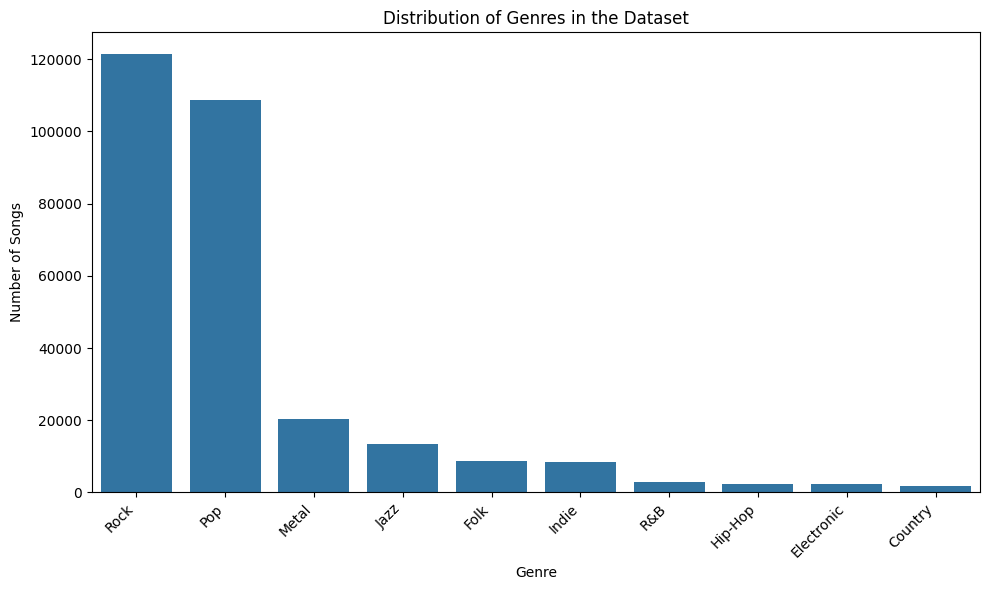

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each genre
genre_counts = training_data['Genre'].value_counts()

# Create a bar plot of the genre distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values)
plt.xlabel('Genre')
plt.ylabel('Number of Songs')
plt.title('Distribution of Genres in the Dataset')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

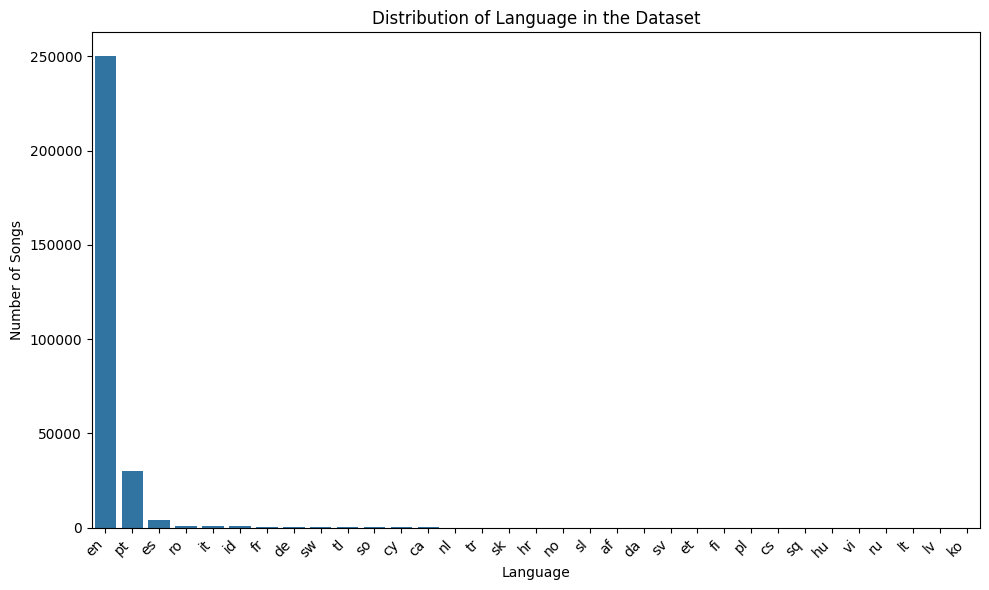

In [58]:
# prompt: Show distribution of rows by language

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'training_data' DataFrame is already loaded as in the provided code

# Count the occurrences of each genre
genre_counts = training_data['Language'].value_counts()

# Create a bar plot of the genre distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values)
plt.xlabel('Language')
plt.ylabel('Number of Songs')
plt.title('Distribution of Language in the Dataset')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

#### Downsampling

In [110]:
!pip install langdetect
from langdetect import detect, DetectorFactory, LangDetectException

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 44.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993222 sha256=4d6ea5b9bfc440880aa73435274e4d0e56d67fcd74cfff76c9be1ac9432b9d12
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [113]:
import pandas as pd
from sklearn.utils import resample
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab') # Download the missing data package
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import torch
import time
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from transformers import XLNetTokenizer, XLNetForSequenceClassification, XLNetConfig, get_linear_schedule_with_warmup
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset, Subset
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import transformers
import itertools

stop_words = set(stopwords.words('english'))

def clean_text(text):
    if pd.isna(text) or not isinstance(text, str):
        return ""
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove special characters and numbers
    text = re.sub(r'[^A-Za-z\s]', '', text)
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text).strip()
    return text

DetectorFactory.seed = 0

def is_english(text):
    cleaned_text = clean_text(text)
    try:
        # Check if the cleaned text is sufficiently long
        if len(cleaned_text) < 20:  # Threshold for minimum length
            return False
        language = detect(cleaned_text)
        return language == 'en'
    except LangDetectException:
        # Log entries that fail language detection
        with open("langdetect_failures.log", "a") as log_file:
            log_file.write(f"Failed detection: {cleaned_text[:100]}...\n")
        return False

def downsample_data(df, target_column, language_column, target_language='en'):
    """
    Filters the DataFrame by a specific language and downsamples the majority classes to match the minority class.

    Args:
        df: The input DataFrame.
        target_column: The name of the column containing the target variable.
        language_column: The name of the column containing the language information.
        target_language: The language to filter the DataFrame by (default is 'en').

    Returns:
        A new DataFrame with downsampled majority classes for the specified language.
    """

    # Filter the DataFrame to include only rows where the language matches the target language
    df = df[df[language_column] == target_language]

    # Calculate the number of samples in the minority class
    minority_class_count = df[target_column].value_counts().min()

    # Create an empty DataFrame to store the downsampled data
    downsampled_df = pd.DataFrame()

    # Iterate over each unique class in the target column
    for class_label in df[target_column].unique():
        # Extract samples belonging to the current class
        class_samples = df[df[target_column] == class_label]

        # If the current class is the majority class, downsample it
        if len(class_samples) > minority_class_count:
            downsampled_class_samples = resample(
                class_samples,
                replace=False,  # Sample without replacement
                n_samples=minority_class_count,  # Downsample to match the minority class
                random_state=42  # Set a random seed for reproducibility
            )
        else:
            # Otherwise, keep the minority class samples as they are
            downsampled_class_samples = class_samples

        # Append the downsampled samples to the downsampled DataFrame
        downsampled_df = pd.concat([downsampled_df, downsampled_class_samples])

    return downsampled_df

# Downsample the training data, only including rows where the language is English
# downsampled_training_data = downsample_data(training_data, target_column='Genre', language_column='Language', target_language='en')
# downsampled_training_data['Lyrics'] = downsampled_training_data['Lyrics'].apply(clean_text)

# Prepare training data
# X_train, X_val, y_train, y_val, tokenizer, label_encoder = prepare_training_data(downsampled_training_data)

training_data['Lyrics'] = training_data['Lyrics'].apply(clean_text)
training_data = training_data[training_data['Lyrics'].apply(is_english)]

new_train_data, _1 = train_test_split(training_data, test_size=0.99, stratify=training_data['Genre'], random_state=42)

# Check distribution in the original data
original_distribution1 = training_data['Genre'].value_counts(normalize=True)

# Check distribution in the stratified sample
sample_distribution1 = new_train_data['Genre'].value_counts(normalize=True)

print("Old_train_data:\n", original_distribution1)
print("New_train_data:\n", sample_distribution1)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Old_train_data:
 Genre
Rock          0.428028
Pop           0.345264
Metal         0.076418
Jazz          0.053216
Folk          0.032624
Indie         0.028929
R&B           0.011042
Hip-Hop       0.008939
Electronic    0.007997
Country       0.007542
Name: proportion, dtype: float64
New_train_data:
 Genre
Rock          0.427944
Pop           0.345309
Metal         0.076248
Jazz          0.053094
Folk          0.032735
Indie         0.029142
R&B           0.011178
Hip-Hop       0.008782
Electronic    0.007984
Country       0.007585
Name: proportion, dtype: float64


In [114]:
# Encode labels
encoder = LabelEncoder()
new_train_data['Genre'] = encoder.fit_transform(new_train_data['Genre'])

# Apply Random Oversampling
ros = RandomOverSampler(random_state=42)
X_resampled1, y_resampled1 = ros.fit_resample(new_train_data[['Lyrics']], new_train_data['Genre'])

train_data = pd.DataFrame({'Lyrics': X_resampled1['Lyrics'].values, 'Genre': y_resampled1.values})

In [115]:
# Dataset class
class LyricsDataset(Dataset):
    def __init__(self, lyrics, genres, tokenizer, max_len):
        self.lyrics = lyrics
        self.genres = genres
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.lyrics)

    def __getitem__(self, item):
        lyric = self.lyrics[item]
        genre = self.genres[item]
        encoding = self.tokenizer.encode_plus(
            lyric,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True,
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(genre, dtype=torch.long)
        }

In [136]:
# Tokenizer and DataLoader
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
max_len = 128
batch_size = 8

train_dataset = LyricsDataset(train_data['Lyrics'].values, train_data['Genre'].values, tokenizer, max_len)

In [137]:
def compute_metrics(labels, preds):
    precision = precision_score(labels, preds, average='macro')
    recall = recall_score(labels, preds, average='macro')
    f1 = f1_score(labels, preds, average='macro')
    return precision, recall, f1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [118]:
# Training function
def train_model(model, data_loader, optimizer, device, scheduler):
    model.train()
    total_loss = 0
    all_labels = []
    all_preds = []

    start_total_time = time.time()  # Start the total training timer

    # Process each batch
    for batch_index, batch in enumerate(data_loader):

        # Transfer batch to device
        batch = {k: v.to(device) for k, v in batch.items()}
        labels = batch['labels']

        # Compute the forward pass and loss
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        # Update parameters and reset gradients
        optimizer.step()
        optimizer.zero_grad()

        # Accumulate the loss and store predictions
        total_loss += loss.item()
        _, preds = torch.max(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Update the learning rate
        scheduler.step()

    # Calculate average loss and accuracy
    avg_loss = total_loss / len(data_loader)
    avg_accuracy = accuracy_score(all_labels, all_preds)

    # End the total training timer and print the total time
    end_total_time = time.time()
    total_training_time = end_total_time - start_total_time
    print(f"Total training time: {total_training_time:.4f} seconds")

    return avg_loss, avg_accuracy, all_labels, all_preds

In [119]:
def validate_model(model, data_loader, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in data_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            total_loss += loss.item()
            _, preds = torch.max(outputs.logits, dim=1)
            correct_predictions += (preds == batch['labels']).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch['labels'].cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1 = compute_metrics(all_labels, all_preds)
    return avg_loss, accuracy, precision, recall, f1, all_labels, all_preds

In [120]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Training fold 1/3


Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Total training time: 75.3748 seconds
Fold 1, Epoch 1, Train Loss: 1.5973238909421217, Train Accuracy: 0.43101035544360483, Val Loss: 0.4712528461773757, Val Accuracy: 0.8284834918858421, Precision: 0.8033002127391284, Recall: 0.8323849824521659, F1 Score: 0.8065271862136172
Total training time: 74.7221 seconds
Fold 1, Epoch 2, Train Loss: 0.32230484511565743, Train Accuracy: 0.8918275958578226, Val Loss: 0.23534423960747836, Val Accuracy: 0.908505875769446, Precision: 0.9088168748974293, Recall: 0.910205493053114, F1 Score: 0.9040088766346772
Total training time: 74.6741 seconds
Fold 1, Epoch 3, Train Loss: 0.1405222113254653, Train Accuracy: 0.9514413657990484, Val Loss: 0.24818599331937521, Val Accuracy: 0.9110240626748741, Precision: 0.9088956560149082, Recall: 0.913015156842064, F1 Score: 0.9091019468811664
Total training time: 74.6375 seconds
Fold 1, Epoch 4, Train Loss: 0.07546688150223844, Train Accuracy: 0.9777497900923594, Val Loss: 0.22209913293183603, Val Accuracy: 0.9264129

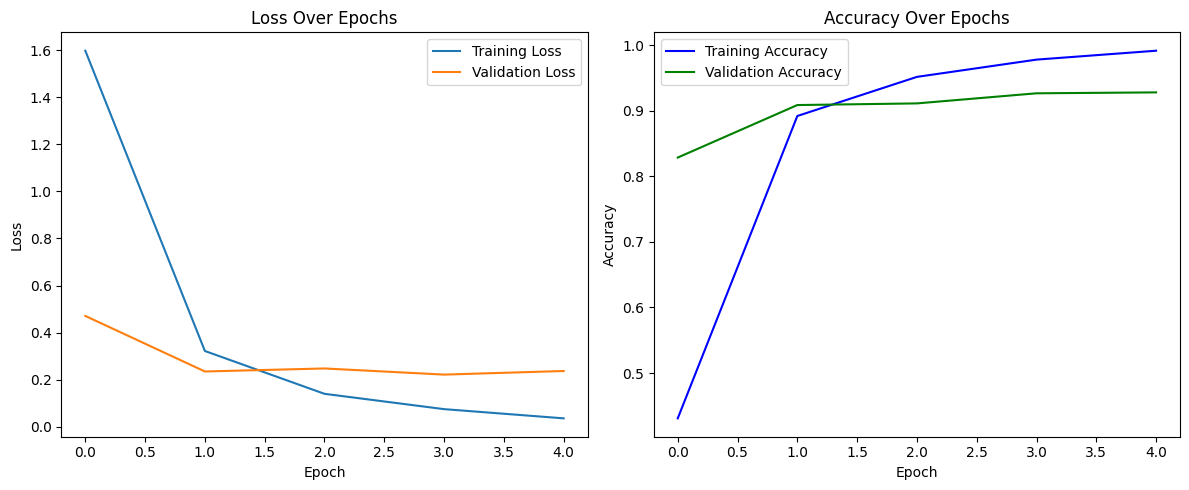

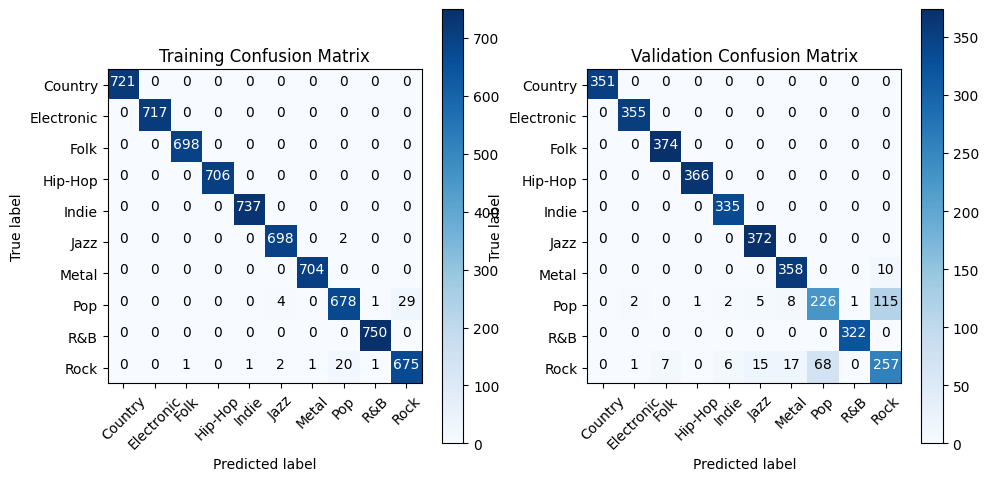

Training fold 2/3


Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Total training time: 74.7907 seconds
Fold 2, Epoch 1, Train Loss: 1.7190167394693798, Train Accuracy: 0.3646285154610326, Val Loss: 0.4250120595795513, Val Accuracy: 0.8508256367198432, Precision: 0.8408687903003893, Recall: 0.8516905673269001, F1 Score: 0.8380116834298384
Total training time: 74.8437 seconds
Fold 2, Epoch 2, Train Loss: 0.2984825149303515, Train Accuracy: 0.892682244298307, Val Loss: 0.22756238142184712, Val Accuracy: 0.9087601455359642, Precision: 0.9263889084025927, Recall: 0.9082200201036406, F1 Score: 0.9065986207658993
Total training time: 74.5334 seconds
Fold 2, Epoch 3, Train Loss: 0.12607150485997465, Train Accuracy: 0.9541066181614664, Val Loss: 0.1632463121789318, Val Accuracy: 0.9325496781416177, Precision: 0.9311781527149853, Recall: 0.933496199423908, F1 Score: 0.9322084900658647
Total training time: 74.3566 seconds
Fold 2, Epoch 4, Train Loss: 0.06303084433293366, Train Accuracy: 0.9785924163984889, Val Loss: 0.18893838135363591, Val Accuracy: 0.93646795

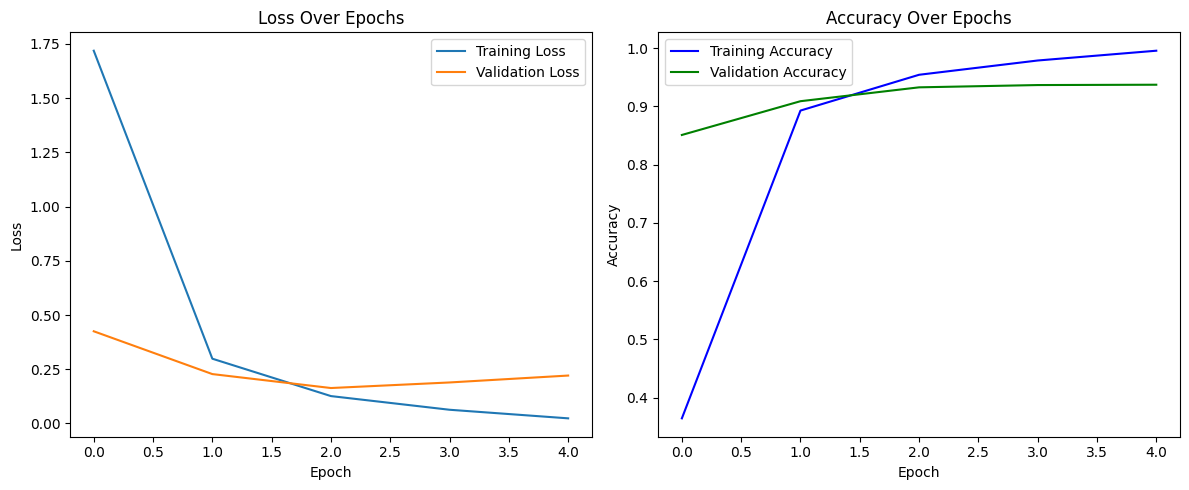

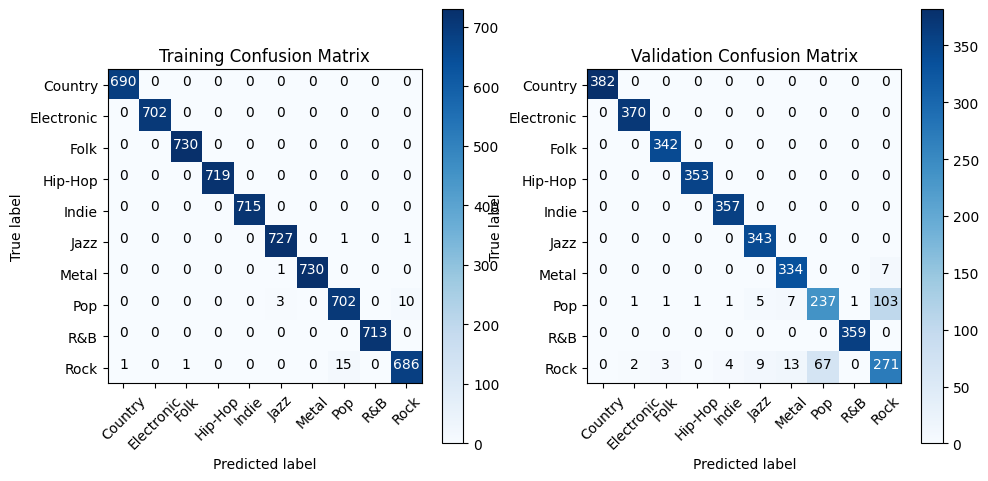

Training fold 3/3


Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Total training time: 73.5186 seconds
Fold 3, Epoch 1, Train Loss: 1.0137714322581388, Train Accuracy: 0.6598572827759899, Val Loss: 0.308631189310219, Val Accuracy: 0.8746151693254968, Precision: 0.8739120372651252, Recall: 0.8714616497183864, F1 Score: 0.8594889575145448
Total training time: 73.9846 seconds
Fold 3, Epoch 2, Train Loss: 0.22911401308022888, Train Accuracy: 0.9171680425353295, Val Loss: 0.1921431330799373, Val Accuracy: 0.9146375594738315, Precision: 0.9148943822053053, Recall: 0.9124271471565276, F1 Score: 0.906337617271683
Total training time: 73.8354 seconds
Fold 3, Epoch 3, Train Loss: 0.10529062983353875, Train Accuracy: 0.9627815866797258, Val Loss: 0.18188048782602154, Val Accuracy: 0.9303106633081444, Precision: 0.9260006064639381, Recall: 0.9279334098119868, F1 Score: 0.925288049689492
Total training time: 74.2833 seconds
Fold 3, Epoch 4, Train Loss: 0.05099475739072692, Train Accuracy: 0.9843290891283056, Val Loss: 0.2772226761361783, Val Accuracy: 0.926672264

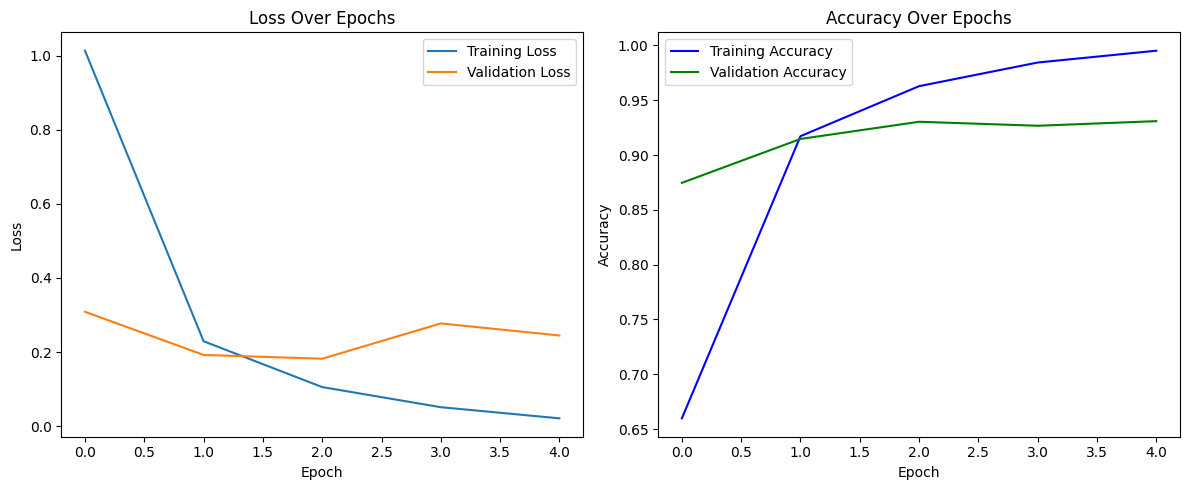

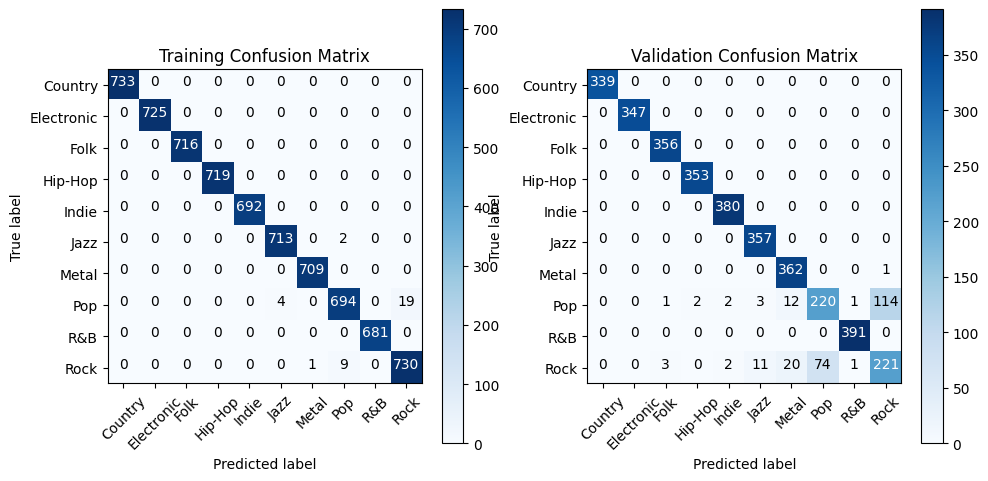

Average Validation Loss, Accuracy, Precision, Recall, F1 over all folds: [0.23426863 0.93190337 0.92934279 0.93179025 0.92982272]


In [138]:
# Define KFold Cross Validator
epochs = 5
num_folds = 3
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize results list for collecting metrics from each fold
fold_results = []
all_train_losses = []
all_val_losses = []
all_train_accuracies = []
all_val_accuracies = []
all_train_preds = []
all_train_labels = []
all_val_preds = []
all_val_labels = []

# Start cross-validation
for fold, (train_idx, val_idx) in enumerate(kf.split(np.arange(len(train_dataset)))):
    print(f"Training fold {fold+1}/{num_folds}")

    # Creating data subsets for the current fold
    train_subsampler = Subset(train_dataset, train_idx)
    val_subsampler = Subset(train_dataset, val_idx)

    # Creating data loaders for the current fold
    train_loader = DataLoader(train_subsampler, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_subsampler, batch_size=8, shuffle=False)

    # Model and optimizer setup for each fold
    config = XLNetConfig.from_pretrained('xlnet-base-cased', num_labels=len(np.unique(y_resampled1)))
    config.update({'hidden_dropout_prob': 0.3, 'attention_probs_dropout_prob': 0.3})
    model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', config=config)
    model.to(device)
    optimizer = AdamW(model.parameters(), lr=2e-5)
    total_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    # Training loop for the current fold
    losses = []
    accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        train_loss, train_accuracy, train_labels, train_preds = train_model(model, train_loader, optimizer, device, scheduler)
        val_loss, val_accuracy, precision, recall, f1, val_labels, val_preds = validate_model(model, val_loader, device)
        losses.append(train_loss)
        accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        print(f'Fold {fold+1}, Epoch {epoch+1}, Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}')

    # Plot training and validation loss and accuracy
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(accuracies, label='Training Accuracy', color='blue')
    plt.plot(val_accuracies, label='Validation Accuracy', color='green')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Plot confusion matrices
    train_cm = confusion_matrix(train_labels, train_preds)
    val_cm = confusion_matrix(val_labels, val_preds)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plot_confusion_matrix(train_cm, classes=encoder.classes_, title='Training Confusion Matrix')
    plt.subplot(1, 2, 2)
    plot_confusion_matrix(val_cm, classes=encoder.classes_, title='Validation Confusion Matrix')
    plt.show()

    # Collect results from the fold
    fold_results.append((val_loss, val_accuracy, precision, recall, f1))
    all_train_losses.append(losses)
    all_val_losses.append(val_losses)
    all_train_accuracies.append(accuracies)
    all_val_accuracies.append(val_accuracies)
    all_train_preds.extend(train_preds)
    all_train_labels.extend(train_labels)
    all_val_preds.extend(val_preds)
    all_val_labels.extend(val_labels)
    torch.save(model.state_dict(), f'model_weights_fold_{fold+1}.pt')

# Average results from all folds
average_results = np.mean(fold_results, axis=0)
print("Average Validation Loss, Accuracy, Precision, Recall, F1 over all folds:", average_results)

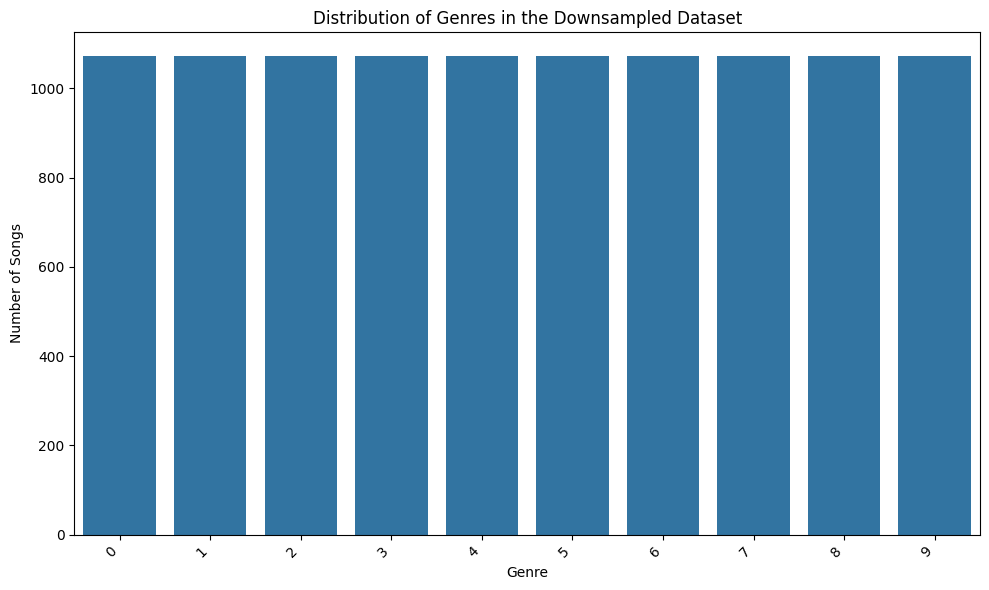

In [125]:
# prompt: Show distribution of classes in downsampled data

# Count the occurrences of each genre in the downsampled data
downsampled_genre_counts = train_data['Genre'].value_counts()

# Create a bar plot of the genre distribution in the downsampled data
plt.figure(figsize=(10, 6))
sns.barplot(x=downsampled_genre_counts.index, y=downsampled_genre_counts.values)
plt.xlabel('Genre')
plt.ylabel('Number of Songs')
plt.title('Distribution of Genres in the Downsampled Dataset')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

## Simple RNN

### Create Simple RNN

In [102]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Embedding(input_dim=10000, output_dim=64),  # Increased embedding dimension
    SimpleRNN(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.3),  # Add dropout and return_sequences
    SimpleRNN(128, dropout=0.3, recurrent_dropout=0.3),  # Second RNN layer
    Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Regularized dense layer
    Dense(len(label_encoder.classes_), activation='softmax')  # Output layer
])

# Compile with reduced learning rate
optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


### Train the Simple RNN model

In [135]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

X_train, X_val, y_train, y_val = train_test_split(
    train_dataset,  # Assuming train_dataset is defined and contains features
    train_data['Genre'],  # Assuming train_data['Genre'] contains the target variable
    test_size=0.2,  # Adjust test_size as needed
    random_state=42  # Set random_state for reproducibility
)

# Updated Callbacks
checkpoint_dir = 'model_checkpoints'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

callbacks = [
    EarlyStopping(
        monitor='val_loss',  # Focus on validation loss for stopping criteria
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath=os.path.join(checkpoint_dir, 'simple_rnn_best_model.keras'),
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',  # Reduce learning rate when validation loss plateaus
        factor=0.5,  # Reduce learning rate by half
        patience=3,  # Wait for 3 epochs before reducing
        verbose=1
    )
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=128,
    callbacks=callbacks,
    verbose=1
)

AttributeError: 'Tokenizer' object has no attribute 'encode_plus'

## Single Layer LSTM

### Create Single Layer LSTM

In [90]:
# Create the LSTM model
lstm_model = Sequential([
  Embedding(input_dim=10000, output_dim=32),  # Same input dimension and output dimension as the RNN model
  LSTM(32),  # LSTM layer with 32 units
  Dense(16, activation='relu'),  # Dense layer with 16 units
  Dense(len(label_encoder.classes_), activation='softmax')  # Output layer with softmax activation
])

# Compile the LSTM model
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display the model summary
lstm_model.summary()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_19 (Embedding)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Train Single Layer LSTM

In [91]:
# Train the LSTM model
lstm_checkpoint_dir = 'lstm_model_checkpoints'
if not os.path.exists(lstm_checkpoint_dir):
  os.makedirs(lstm_checkpoint_dir)

lstm_callbacks = [
  EarlyStopping(
    monitor='accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
  ),
  ModelCheckpoint(
    filepath=os.path.join(lstm_checkpoint_dir, 'lstm_best_model.keras'),
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
  )
]

lstm_history = lstm_model.fit(
  X_train, y_train,
  validation_data=(X_val, y_val),
  epochs=50,
  batch_size=64,
  callbacks=lstm_callbacks,
  verbose=1
)

Epoch 1/50
236/237 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1524 - loss: 2.2553
Epoch 1: val_accuracy improved from -inf to 0.19233, saving model to lstm_model_checkpoints/lstm_best_model.keras
237/237 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.1526 - loss: 2.2549 - val_accuracy: 0.1923 - val_loss: 2.1391
Epoch 2/50
234/237 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2133 - loss: 2.0897
Epoch 2: val_accuracy improved from 0.19233 to 0.20979, saving model to lstm_model_checkpoints/lstm_best_model.keras
237/237 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.2133 - loss: 2.0896 - val_accuracy: 0.2098 - val_loss: 2.1224
Epoch 3/50
233/237 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2277 - loss: 2.0165
Epoch 3: val_accuracy did not improve from 0.20979
237/237 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.2278 - loss: 2.0165 - val_accuracy: 0.2082 - val_loss: 2.1056
Epoch 4/50
234/237 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2536 - loss: 1.9632
Epoch 4: val_accuracy i

## Multi-Layer LSTM

### Create Multi-Layer LSTM

In [22]:
multi_lstm_model = Sequential([
  Embedding(input_dim=10000, output_dim=32),  # Same input dimension and output dimension as the single-layer LSTM model
  LSTM(32, return_sequences=True),  # First LSTM layer with 32 units, return sequences
  LSTM(32),  # Second LSTM layer with 32 units
  Dense(16, activation='relu'),  # Dense layer with 16 units
  Dense(len(label_encoder.classes_), activation='softmax')  # Output layer with softmax activation
])

# Compile the multi-layer LSTM model
multi_lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display the model summary
multi_lstm_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Train Multi-Layer LSTM

In [36]:
multi_lstm_checkpoint_dir = 'multi_lstm_model_checkpoints'
if not os.path.exists(multi_lstm_checkpoint_dir):
  os.makedirs(multi_lstm_checkpoint_dir)

multi_lstm_callbacks = [
  EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
  ),
  ModelCheckpoint(
    filepath=os.path.join(multi_lstm_checkpoint_dir, 'multi_lstm_best_model.keras'),
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
  )
]

multi_lstm_history = multi_lstm_model.fit(
  X_train, y_train,
  validation_data=(X_val, y_val),
  epochs=50,
  batch_size=64,
  callbacks=multi_lstm_callbacks,
  verbose=1
)

Epoch 1/50
235/237 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9802 - loss: 0.0701
Epoch 1: val_accuracy improved from -inf to 0.28280, saving model to multi_lstm_model_checkpoints/multi_lstm_best_model.keras
237/237 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9802 - loss: 0.0700 - val_accuracy: 0.2828 - val_loss: 7.7177
Epoch 2/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9814 - loss: 0.0661
Epoch 2: val_accuracy did not improve from 0.28280
237/237 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9814 - loss: 0.0662 - val_accuracy: 0.2799 - val_loss: 7.9893
Epoch 3/50
236/237 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9818 - loss: 0.0698
Epoch 3: val_accuracy did not improve from 0.28280
237/237 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9818 - loss: 0.0698 - val_accuracy: 0.2791 - val_loss: 8.0088
Epoch 4/50
236/237 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9724 - loss: 0.0946
Epoch 4: val_accuracy did not improve from 0.28280
237/237 ━━━━━━━━━━━

## Compare Models

In [106]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Load the test data
test_data_path = os.path.join(data_dir, 'test.csv')
test_data = pd.read_csv(test_data_path)

# Preprocess the test data using the same tokenizer and label encoder
lyrics_test = test_data['Lyrics'].astype(str).values
genres_test = test_data['Genre'].values
sequences_test = tokenizer.texts_to_sequences(lyrics_test)
padded_sequences_test = pad_sequences(sequences_test, maxlen=100, padding='post', truncating='post')
encoded_labels_test = label_encoder.transform(genres_test)

# Evaluate each model
models = {
    'Simple RNN': model,
    'Single Layer LSTM': lstm_model,
    'Multi-Layer LSTM': multi_lstm_model
}

results = {}
for model_name, model in models.items():
  _, accuracy = model.evaluate(padded_sequences_test, encoded_labels_test, verbose=0)
  y_pred = np.argmax(model.predict(padded_sequences_test), axis=1)
  results[model_name] = {
      'Accuracy': accuracy,
      'Classification Report': classification_report(encoded_labels_test, y_pred, target_names=label_encoder.classes_),
      'Confusion Matrix': confusion_matrix(encoded_labels_test, y_pred)
  }
  print(f"{model_name} Accuracy: {accuracy}")
  print(f"{model_name} Classification Report:\n{results[model_name]['Classification Report']}")

# Visualize the results
accuracy_scores = [results[model_name]['Accuracy'] for model_name in models]
model_names = list(models.keys())

plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracy_scores, color=['skyblue', 'lightcoral', 'lightgreen'])
plt.title('Model Accuracy Comparison on Test Data')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()


# Example: Visualizing Confusion Matrix for the best-performing model (assuming Multi-Layer LSTM is best)
# You can adapt this to visualize confusion matrix for other models too.
best_model_name = max(results, key=lambda k: results[k]['Accuracy'])
cm = results[best_model_name]['Confusion Matrix']

plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.colorbar()
tick_marks = np.arange(len(label_encoder.classes_))
plt.xticks(tick_marks, label_encoder.classes_, rotation=45)
plt.yticks(tick_marks, label_encoder.classes_)

thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
  plt.text(j, i, format(cm[i, j], 'd'),
           horizontalalignment="center",
           color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None,), output.shape=(None, 10)

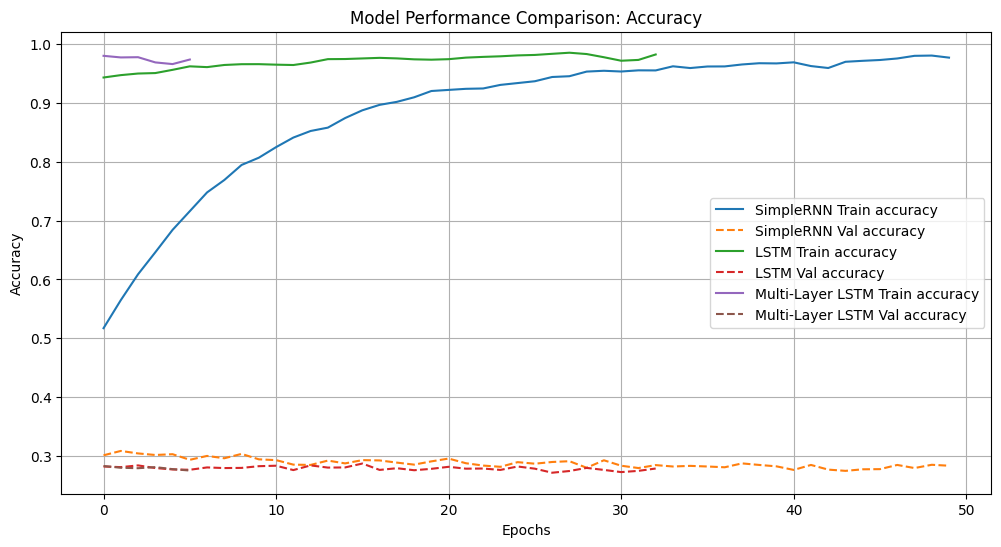

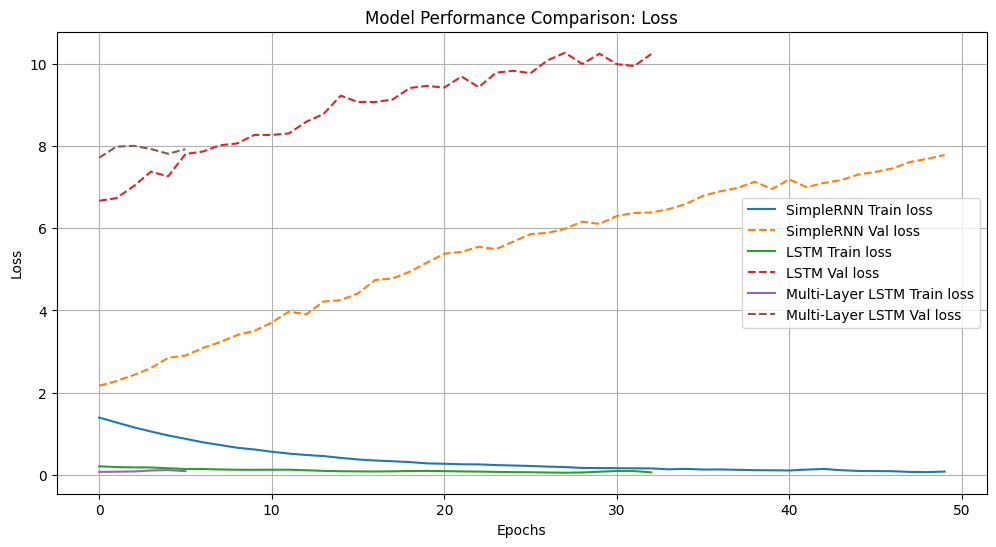

In [38]:
# Adjusted function to handle dictionary-like mock data directly
def plot_model_performance_direct(histories, model_names, metric="accuracy"):
    plt.figure(figsize=(12, 6))

    for history, model_name in zip(histories, model_names):
        # Access metrics using dot notation (.) instead of square brackets ([])
        plt.plot(history.history[metric], label=f'{model_name} Train {metric}')
        plt.plot(history.history[f'val_{metric}'], linestyle='--', label=f'{model_name} Val {metric}')

    plt.title(f'Model Performance Comparison: {metric.capitalize()}')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualizing performance with the adjusted function
plot_model_performance_direct(
    histories=[history, lstm_history, multi_lstm_history],
    model_names=["SimpleRNN", "LSTM", "Multi-Layer LSTM"],
    metric="accuracy"
)

plot_model_performance_direct(
    histories=[history, lstm_history, multi_lstm_history],
    model_names=["SimpleRNN", "LSTM", "Multi-Layer LSTM"],
    metric="loss"
)
